In [1]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel

# import adapters
# from adapters import AutoAdapterModel
# import gc

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# from sklearn.decomposition import TruncatedSVD
# from sklearn.preprocessing import normalize

# from openTSNE import TSNE, affinity

import matplotlib.pyplot as plt
import matplotlib as mpl


import pickle
import time
import memory_profiler
from tqdm.notebook import tqdm

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [2]:
# old one '1.8.1+cu111'
torch.__version__

'2.1.1+cu121'

In [31]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import train_loop
from text_embeddings_src.data_stuff import (
    SameSentencePairDataset,
)
from text_embeddings_src.embeddings import generate_embeddings

# from text_embeddings_src.metrics import knn_accuracy, logistic_accuracy
# from text_embeddings_src.dim_red import run_tsne_simple
# from text_embeddings_src.plotting import plot_tsne_colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [5]:
variables_path = Path("../../results/variables")
# variables_pubmed_path = Path("../../pubmed-landscape/results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [6]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [7]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [8]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers -p openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-07-25 11:44:31CEST

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

openTSNE: 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

torch              : 2.1.1
numpy              : 1.26.2
scipy              : 1.11.4
distro             : 1.8.0
memory_profiler    : 0.61.0
sklearn            : 1.3.2
text_embeddings_src: 0.0.0
pandas             : 2.1.3
matplotlib         : 3.8.2
black              : 23.11.0
jupyter_black      : 0.3.4

Watermark: 2.4.3

Ubuntu 22.04.3 LTS


# Import ICLR dataset

In [34]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

CPU times: user 287 ms, sys: 79.8 ms, total: 367 ms
Wall time: 264 ms


In [35]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [36]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [37]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

In [38]:
# sanity check
print(len(np.unique(labels_iclr)))
labels_iclr

46


array(['unlabeled', 'unlabeled', 'optimization', ..., 'unlabeled',
       'unlabeled', 'federated learning'], dtype='<U34')

# Functions

In [27]:
def fix_all_seeds(seed=42):
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  ## this one is new
    ## Set the seed for generating random numbers on all GPUs.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True) ## this one I don't use but don't remember why

    # Set the random seed for NumPy
    np.random.seed(seed)

    # Set the random seed
    random.seed(seed)

## Function train model without evaluation

In [28]:
# import torch
# from tqdm.notebook import tqdm
# from transformers.optimization import get_linear_schedule_with_warmup
# from text_embeddings_src.model_stuff import mean_pool


# def train_loop_without_eval(
#     model,
#     loader,
#     device,
#     optimized_rep="av",
#     n_epochs=1,
#     lr=2e-5,
# ):
#     assert optimized_rep in [
#         "av",
#         "cls",
#         "sep",
#         "7th",
#     ], "Not valid `optimized_rep`. Choose from ['av', 'cls', 'sep', '7th']."

#     model.to(device)

#     # define layers to be used in multiple-negatives-ranking
#     cos_sim = torch.nn.CosineSimilarity()
#     loss_func = torch.nn.CrossEntropyLoss()
#     scale = 20.0  # we multiply similarity score by this scale value, it is the inverse of the temperature
#     # move layers to device
#     cos_sim.to(device)
#     loss_func.to(device)

#     # initialize Adam optimizer
#     optim = torch.optim.Adam(model.parameters(), lr=lr)

#     # setup warmup for first ~10% of steps
#     total_steps = len(loader) * n_epochs
#     warmup_steps = int(0.1 * len(loader))
#     scheduler = get_linear_schedule_with_warmup(
#         optim,
#         num_warmup_steps=warmup_steps,
#         num_training_steps=total_steps,
#     )

#     losses = np.empty((n_epochs, len(loader)))
#     accuracies = []
#     for epoch in range(n_epochs):
#         model.train()  # make sure model is in training mode
#         # initialize the dataloader loop with tqdm (tqdm == progress bar)
#         loop = tqdm(loader, leave=True)
#         for i_batch, batch in enumerate(loop):
#             # zero all gradients on each new step
#             optim.zero_grad()
#             # prepare batches and move all to the active device
#             anchor_ids = batch[0][0].to(
#                 device
#             )  # this are all anchor abstracts from the batch,len(anchor_ids)= len(batch)
#             anchor_mask = batch[0][1].to(device)
#             pos_ids = batch[1][0].to(
#                 device
#             )  # this each positive pair from each anchor, all in one array, also len(batch)
#             pos_mask = batch[1][1].to(device)
#             # extract token embeddings from BERT
#             a = model(anchor_ids, attention_mask=anchor_mask)[
#                 0
#             ]  # all token embeddings
#             p = model(pos_ids, attention_mask=pos_mask)[0]

#             # get the mean pooled vectors  -- put all of these ifs into a pool function (wraper) to which I pass, a, p the masks and the optimized rep
#             if optimized_rep == "av":
#                 a = mean_pool(a, anchor_mask)
#                 p = mean_pool(p, pos_mask)

#             elif optimized_rep == "cls":
#                 a = cls_pool(a, anchor_mask)
#                 p = cls_pool(p, pos_mask)

#             elif optimized_rep == "sep":
#                 a = sep_pool(a, anchor_mask)
#                 p = sep_pool(p, pos_mask)

#             elif optimized_rep == "7th":
#                 a = seventh_pool(a, anchor_mask)
#                 p = seventh_pool(p, pos_mask)

#             # calculate the cosine similarities
#             scores = torch.stack(
#                 [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
#             )
#             # get label(s) - we could define this before if confident
#             # of consistent batch sizes
#             labels = torch.tensor(
#                 range(len(scores)), dtype=torch.long, device=scores.device
#             )  # I think that the labels are just the label of which pair it is. 0 for the first pair, 1 for the second...
#             # my guess is that they are used in the loss to know which of the cosine similarities should be high
#             # and which low

#             # and now calculate the loss
#             loss = loss_func(scores * scale, labels)
#             losses[epoch, i_batch] = loss.item()

#             # using loss, calculate gradients and then optimize
#             loss.backward()
#             optim.step()
#             # update learning rate scheduler
#             scheduler.step()
#             # update the TDQM progress bar
#             loop.set_description(f"Epoch {epoch}")
#             loop.set_postfix(loss=loss.item())

#         return model, losses

## function get embeddings of all tokens -- NOT NECESSARY

In [19]:
# import datasets
# from tqdm.notebook import tqdm


# def generate_embeddings_all_tokens(
#     abstracts,
#     tokenizer,
#     model,
#     device,
#     batch_size=256,
#     show_progress=False,
# ):
#     """Generate embeddings using BERT-based model.

#     Parameters
#     ----------
#     abstracts : list, this has to be a list not sure if array works but pandas do not work
#         Abstract texts.
#     tokenizer : transformers.models.bert.tokenization_bert_fast.BertTokenizerFast
#         Tokenizer.
#     model : transformers.models.bert.modeling_bert.BertModel
#         BERT-based model.
#     device : str, {"cuda", "cpu"}
#         "cuda" if torch.cuda.is_available() else "cpu".

#     Returns
#     -------
#     embedding_cls : ndarray
#         [CLS] tokens of the abstracts.
#     embedding_sep : ndarray
#         [SEP] tokens of the abstracts.
#     embedding_av : ndarray
#         Average of tokens of the abstracts.
#     """
#     # preprocess the input
#     inputs = tokenizer(
#         abstracts,
#         padding=True,
#         truncation=True,
#         return_tensors="pt",
#         max_length=512,
#     ).to(device)

#     dataset = datasets.Dataset.from_dict(inputs)
#     dataset.set_format(type="torch", output_all_columns=True)
#     loader = torch.utils.data.DataLoader(
#         dataset, batch_size=batch_size, num_workers=10
#     )

#     embedding = []

#     with torch.no_grad():
#         model.eval()

#         for batch in tqdm(loader) if show_progress == True else loader:
#             batch = {k: v.to(device) for k, v in batch.items()}
#             out = model(**batch)
#             token_embeds = out[0]  # get the last hidden state
#             embedding.append(token_embeds.detach().cpu().numpy())

#     embedding = np.vstack(embedding)
#     return embedding

In [20]:
# import datasets
# from tqdm.notebook import tqdm


# def generate_embeddings_all_tokens_across_layers(
#     abstracts,
#     tokenizer,
#     model,
#     device,
#     layers,
#     batch_size=256,
#     show_progress=False,
# ):
#     """Generate embeddings using BERT-based model.

#     Parameters
#     ----------
#     abstracts : list, this has to be a list not sure if array works but pandas do not work
#         Abstract texts.
#     tokenizer : transformers.models.bert.tokenization_bert_fast.BertTokenizerFast
#         Tokenizer.
#     model : transformers.models.bert.modeling_bert.BertModel
#         BERT-based model.
#     device : str, {"cuda", "cpu"}
#         "cuda" if torch.cuda.is_available() else "cpu".

#     Returns
#     -------
#     embedding_cls : ndarray
#         [CLS] tokens of the abstracts.
#     embedding_sep : ndarray
#         [SEP] tokens of the abstracts.
#     embedding_av : ndarray
#         Average of tokens of the abstracts.
#     """
#     # preprocess the input
#     inputs = tokenizer(
#         abstracts,
#         padding=True,
#         truncation=True,
#         return_tensors="pt",
#         max_length=512,
#     ).to(device)

#     dataset = datasets.Dataset.from_dict(inputs)
#     dataset.set_format(type="torch", output_all_columns=True)
#     loader = torch.utils.data.DataLoader(
#         dataset, batch_size=batch_size, num_workers=10
#     )

#     embeddings_layers = dict()

#     with torch.no_grad():
#         model.eval()

#         for i, batch in (
#             enumerate(tqdm(loader))
#             if show_progress == True
#             else enumerate(loader)
#         ):
#             batch = {k: v.to(device) for k, v in batch.items()}
#             out = model(**batch, output_hidden_states=True)

#             for layer_number in layers:
#                 if i == 0:
#                     embeddings_layers[layer_number] = [
#                         out.hidden_states[layer_number].detach().cpu().numpy()
#                     ]
#                 else:
#                     embeddings_layers[layer_number].append(
#                         out.hidden_states[layer_number].detach().cpu().numpy()
#                     )

#     # convert to array
#     for layer_number in layers:
#         embeddings_layers[layer_number] = np.vstack(
#             embeddings_layers[layer_number]
#         )

#     return embeddings_layers

# Outlier dimensions

## Untrained

In [14]:
# save embeddings
model_name = "MPNet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

embedding_cls_untrained = np.load(
    variables_path / saving_path / "embedding_abstracts_only_cls.npy"
)
embedding_sep_untrained = np.load(
    variables_path / saving_path / "embedding_abstracts_only_sep.npy"
)
embedding_av_untrained = np.load(
    variables_path / saving_path / "embedding_abstracts_only_av.npy"
)

In [15]:
embedding_av_untrained.shape

(24347, 768)

### Plot

CPU times: user 8min 39s, sys: 754 ms, total: 8min 40s
Wall time: 8min 41s


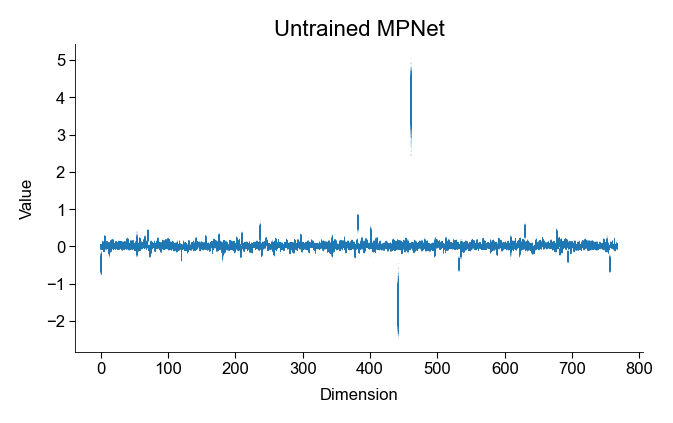

In [24]:
%%time

%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200, layout="constrained")

for i in range(embedding_av_untrained.shape[0]):  # 24347
    ax.scatter(
        np.arange(embedding_av_untrained.shape[1]),
        embedding_av_untrained[i],
        c="tab:blue",
        s=0.5,
        alpha=0.3,
        marker=".",
        linewidths=0,
        ec="None",
        rasterized=True,
    )
ax.set_xlabel("Dimension")
ax.set_ylabel("Value")
ax.set_title("Untrained MPNet")

fig.savefig(figures_path / "dimension_values_untrained_mpnet.png")

## Trained

In [25]:
# save embeddings
model_name = "MPNet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

embedding_cls_trained = np.load(
    variables_path
    / saving_path
    / "embedding_asbtracts_only_cls_after_training_cls_1_epoch.npy"
)  # CAREFUL, TRAINED ON CLS
# embedding_sep_trained = np.load(variables_path/saving_path/"embedding_abstracts_only_sep.npy")
embedding_av_trained = np.load(
    variables_path
    / saving_path
    / "embedding_asbtracts_only_av_after_training_av_1_epoch.npy"
)

In [18]:
embedding_av_trained.shape

(24347, 768)

### Plot

CPU times: user 8min 25s, sys: 1.23 s, total: 8min 26s
Wall time: 8min 26s


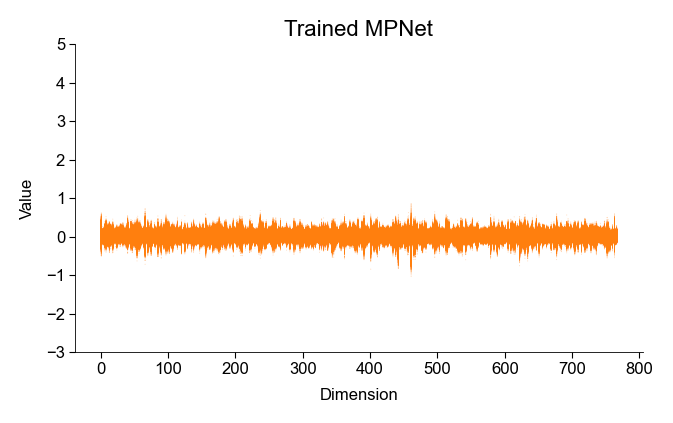

In [49]:
%%time

%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200, layout="constrained")

for i in range(embedding_av_trained.shape[0]):  # 24347
    ax.scatter(
        np.arange(embedding_av_trained.shape[1]),
        embedding_av_trained[i],
        c="tab:orange",
        s=0.5,
        alpha=0.3,
        marker=".",
        linewidths=0,
        ec="None",
        rasterized=True,
    )
ax.set_xlabel("Dimension")
ax.set_ylabel("Value")
ax.set_ylim(-3, 5)
ax.set_title("Trained MPNet")

fig.savefig(figures_path / "dimension_values_trained_mpnet_v2.png")

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f75d19760c0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

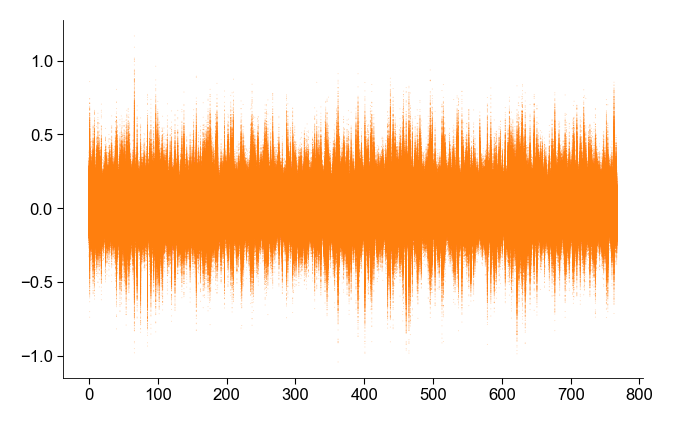

In [52]:
%%time

%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200, layout="constrained")

for i in range(embedding_cls_trained.shape[0]):  # 24347
    ax.scatter(
        np.arange(embedding_cls_trained.shape[1]),
        embedding_cls_trained[i],
        c="tab:orange",
        s=0.5,
        alpha=0.3,
        marker=".",
        linewidths=0,
        ec="None",
        rasterized=True,
    )
ax.set_xlabel("Dimension")
ax.set_ylabel("Value")
ax.set_ylim(-3, 5)
ax.set_title("Trained MPNet [CLS]")

fig.savefig(figures_path / "dimension_values_trained_cls_mpnet_cls_v2.png")

## Trained (SimCSE-like) -- DO NOT RUN YET

In [29]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [41]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = SameSentencePairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
(
    losses,
    knn_accuracies,
    embedding_cls_trained_simcse,
    embedding_sep_trained_simcse,
    embedding_av_trained_simcse,
) = train_loop(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
    return_embeddings=True,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

# np.save(variables_path / saving_path / "losses_run5", losses)
# np.save(
#     variables_path / saving_path / "knn_accuracies_run5",
#     knn_accuracies,
# )

np.save(
    variables_path
    / saving_path
    / "embedding_abstract_only_cls_after_training_simcse_av_1_epoch",  # embedding_asbtracts_only_av_after_training_av_1_epoch
    embedding_cls_trained_simcse,
)
np.save(
    variables_path
    / saving_path
    / "embedding_abstract_only_sep_after_training_simcse_av_1_epoch",
    embedding_sep_trained_simcse,
)
np.save(
    variables_path
    / saving_path
    / "embedding_abstract_only_av_after_training_simcse_av_1_epoch",
    embedding_av_trained_simcse,
)

print("----------------------------")

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 8min 29s, sys: 7min 11s, total: 15min 40s
Wall time: 8min 46s


In [ ]:
# # reload embeddings
# model_name= "MPNet"
# saving_path = Path("embeddings_" + model_name.lower()) / Path("updated_dataset")

# embedding_av_trained_simcse = np.load(variables_path/saving_path/"embedding_abstract_only_av_after_training_simcse_av_1_epoch.npy")

In [42]:
embedding_av_trained_simcse.shape

(24347, 768)

### Plot

CPU times: user 8min 38s, sys: 1.39 s, total: 8min 39s
Wall time: 8min 40s


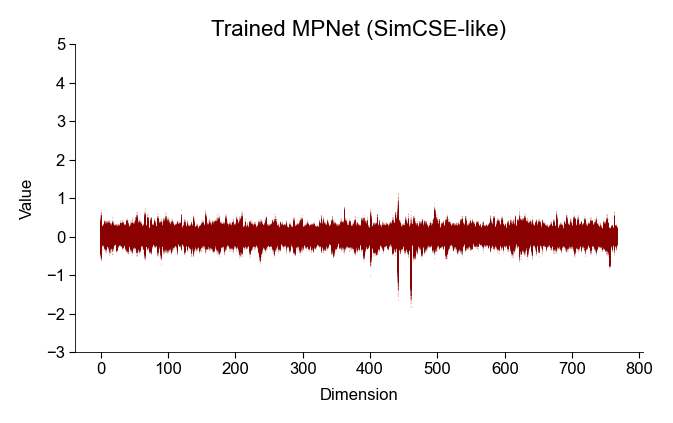

In [48]:
%%time

%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200, layout="constrained")

for i in range(embedding_av_trained_simcse.shape[0]):  # 24347
    ax.scatter(
        np.arange(embedding_av_trained_simcse.shape[1]),
        embedding_av_trained_simcse[i],
        c="darkred",
        s=0.5,
        alpha=0.3,
        marker=".",
        linewidths=0,
        ec="None",
        rasterized=True,
    )
ax.set_xlabel("Dimension")
ax.set_ylabel("Value")
ax.set_ylim(-3, 5)
ax.set_title("Trained MPNet (SimCSE-like)")

fig.savefig(figures_path / "dimension_values_trained_simcse_mpnet_v2.png")

## Untrained SimCSE

In [21]:
# save embeddings
model_name = "SimCSE"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

embedding_cls_untrained_simcse = np.load(
    variables_path / saving_path / "embedding_abstracts_only_cls.npy"
)
# embedding_sep_untrained_simcse = np.load(
#     variables_path / saving_path / "embedding_abstracts_only_sep.npy"
# )
embedding_av_untrained_simcse = np.load(
    variables_path / saving_path / "embedding_abstracts_only_av.npy"
)

In [20]:
embedding_av_untrained.shape

(24347, 768)

### Plot

CPU times: user 8min 26s, sys: 1.25 s, total: 8min 27s
Wall time: 8min 28s


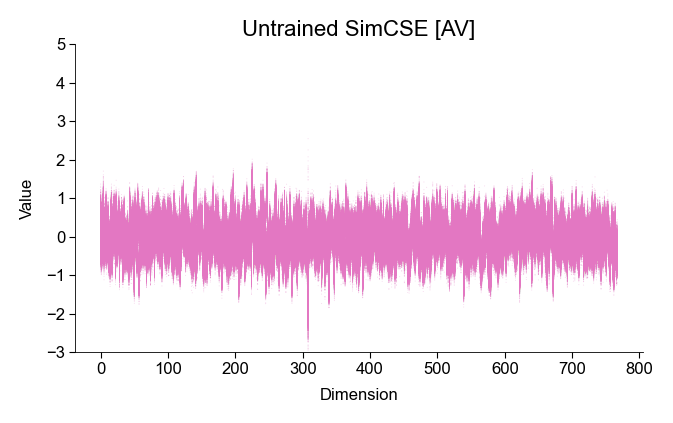

In [50]:
%%time

%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200, layout="constrained")

for i in range(embedding_av_untrained_simcse.shape[0]):  # 24347
    ax.scatter(
        np.arange(embedding_av_untrained_simcse.shape[1]),
        embedding_av_untrained_simcse[i],
        c="tab:pink",
        s=0.5,
        alpha=0.3,
        marker=".",
        linewidths=0,
        ec="None",
        rasterized=True,
    )
ax.set_xlabel("Dimension")
ax.set_ylabel("Value")
ax.set_ylim(-3, 5)
ax.set_title("Untrained SimCSE [AV]")

fig.savefig(figures_path / "dimension_values_untrained_simcse_av_v2.png")

CPU times: user 8min 23s, sys: 1.17 s, total: 8min 24s
Wall time: 8min 24s


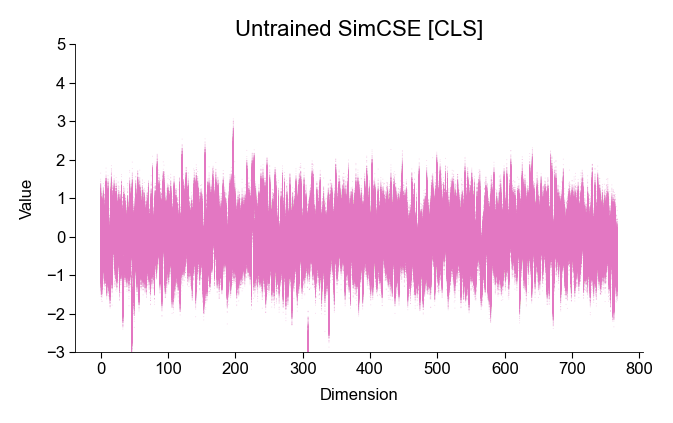

In [51]:
%%time

%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200, layout="constrained")

for i in range(embedding_cls_untrained_simcse.shape[0]):  # 24347
    ax.scatter(
        np.arange(embedding_cls_untrained_simcse.shape[1]),
        embedding_cls_untrained_simcse[i],
        c="tab:pink",
        s=0.5,
        alpha=0.3,
        marker=".",
        linewidths=0,
        ec="None",
        rasterized=True,
    )
ax.set_xlabel("Dimension")
ax.set_ylabel("Value")
ax.set_ylim(-3, 5)
ax.set_title("Untrained SimCSE [CLS]")

fig.savefig(figures_path / "dimension_values_untrained_simcse_cls_v2.png")

# Correlation analysis
Things to take into account:
- exclude the pad tokens from the MPNet's output
- individual correlation for each document, and then average across all documents? This compare untrained vs. trained

In [318]:
print(inputs["attention_mask"].shape)
inputs["attention_mask"][0]

torch.Size([24347, 512])


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [323]:
print(
    len(tfidf_original_weights_iclr[0])
    == np.sum(inputs["attention_mask"][0].detach().cpu().numpy()) - 2
)

True


In [ ]:
# Two vectors are
for i in range(len(tfidf_original_weights_iclr)): #24347
    tfidf_original_weights_iclr[i]
    == np.sum(inputs["attention_mask"][0].detach().cpu().numpy()) - 2
)

True


### Plot

In [378]:
# test bool
i = 2855
a = trained_token_norms_iclr[i]
b = inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)

# print(a)
print(a.shape)
print(type(a))
# print(b)
print(b.shape)
print(type(b))

print(a[b].shape)
a[b]

(512,)
<class 'numpy.ndarray'>
(512,)
<class 'numpy.ndarray'>
(216,)


array([4.6634564, 4.566086 , 4.1363297, 4.059316 , 4.0758924, 3.916474 ,
       3.9771478, 3.8102846, 3.8651187, 3.9940674, 3.896902 , 3.8408155,
       3.945585 , 4.1850886, 4.001016 , 3.823303 , 3.9026053, 3.8345504,
       3.9288454, 3.7825089, 4.222973 , 4.0400295, 4.145305 , 4.231133 ,
       4.2247934, 4.141707 , 3.8142252, 3.8873258, 4.258106 , 4.118116 ,
       3.739085 , 3.8605988, 4.0316286, 3.80481  , 4.047982 , 3.6553211,
       3.9082956, 3.8718028, 4.00169  , 3.839654 , 3.8636525, 4.090888 ,
       3.9849553, 4.3103166, 3.7105267, 3.992409 , 3.9679708, 4.090531 ,
       3.9952555, 4.171709 , 3.797471 , 4.0774274, 3.7455041, 4.096928 ,
       4.1058526, 3.714056 , 3.798226 , 4.0103526, 4.1179147, 3.977459 ,
       4.3661175, 4.0610375, 3.7352498, 4.1796412, 3.7635207, 3.9105508,
       3.8757699, 3.8799648, 3.9084113, 3.9566634, 4.36568  , 3.8485026,
       4.401986 , 3.8467712, 4.0129538, 3.9602413, 4.0524335, 3.7143767,
       3.678224 , 3.9876583, 4.081065 , 3.8691993, 

In [379]:
tfidf_original_weights_iclr[i].shape

(212,)

In [383]:
print(np.array(tokenizer.convert_ids_to_tokens(inputs["input_ids"][i])))

['<s>' 'we' 'study' 'discrete' 'time' 'dynamic' '##al' 'systems'
 'governed' 'by' 'the' 'state' 'equation' '$' 'h' '_' '{' 't' '+' '1' '}'
 '=' '[UNK]' '(' 'ah' '_' 't' '+' 'bu' '_' 't' ')' '$' '.' 'here' 'a' ','
 'b' 'are' 'weight' 'matrices' ',' '[UNK]' 'is' 'an' 'activation'
 'function' ',' 'and' '$' 'u' '_' 't' '$' 'is' 'the' 'input' 'data' '.'
 'this' 'relation' 'is' 'the' 'backbone' 'of' 'rec' '##urrent' 'neural'
 'networks' '(' 'e' '.' 'g' '.' 'l' '##st' '##ms' ')' 'which' 'have'
 'broad' 'applications' 'in' 'sequential' 'learning' 'tasks' '.' 'we'
 'utilize' 'st' '##och' '##astic' 'gradient' 'descent' 'to' 'learn' 'the'
 'weight' 'matrices' 'from' 'a' 'finite' 'input' '/' 'state' 'trajectory'
 '$' '(' 'u' '_' 't' ',' 'h' '_' 't' ')' '_' '{' 't' '=' '0' '}' '^' 'n'
 '$' '.' 'we' 'prove' 'that' 'sg' '##d' 'estimate' 'linear' '##ly'
 'converge' '##s' 'to' 'the' 'ground' 'truth' 'weights' 'while' 'using'
 'near' '-' 'optimal' 'sample' 'size' '.' 'our' 'results' 'apply' 'to'
 'incre

In [385]:
print(iclr2024.abstract.iloc[2855])

We study discrete time dynamical systems governed by the state equation $h_{t+1}=ϕ(Ah_t+Bu_t)$. Here A,B are weight matrices, ϕ is an activation function, and $u_t$ is the input data. This relation is the backbone of recurrent neural networks (e.g. LSTMs) which have broad applications in sequential learning tasks. We utilize stochastic gradient descent to learn the weight matrices from a finite input/state trajectory $(u_t,h_t)_{t=0}^N$. We prove that SGD estimate linearly converges to the ground truth weights while using near-optimal sample size. Our results apply to increasing activations whose derivatives are bounded away from zero. The analysis is based on i) an SGD convergence result with nonlinear activations and ii) careful statistical characterization of the state vector. Numerical experiments verify the fast convergence of SGD on ReLU and leaky ReLU in consistence with our theory.


In [ ]:
# making sure the input is the correct one
tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
inputs = tokenizer(
    iclr2024.abstract.to_list(),
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

In [496]:
mpl.rcParams["axes.spines.right"] = False

CPU times: user 7min 59s, sys: 3.93 s, total: 8min 3s
Wall time: 8min 4s


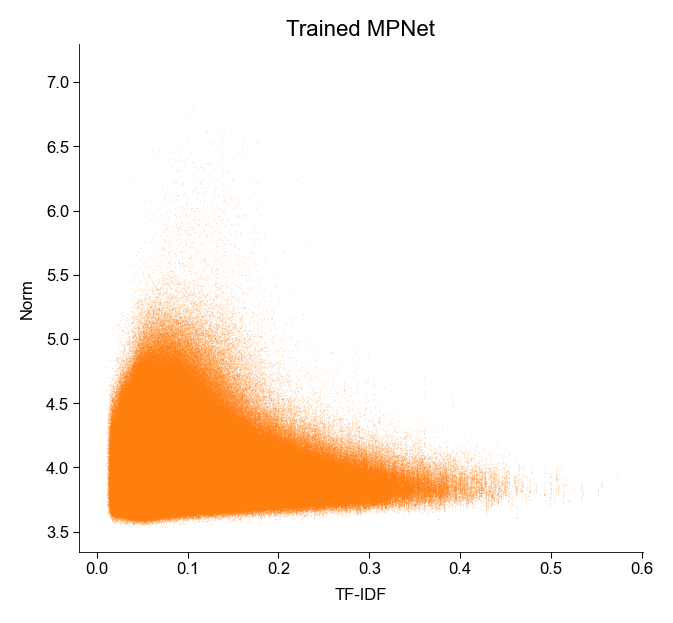

In [386]:
%%time

%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 3), dpi=200, layout="constrained")
n_not_maching = 0
for i in range(len(tfidf_original_weights_iclr)):  # 24347
    # assert (
    #     tfidf_original_weights_iclr[i].shape
    #     == trained_token_norms_iclr[i][
    #         inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
    #     ][1:-1].shape
    # ), f"{i}"

    if (
        tfidf_original_weights_iclr[i].shape
        != trained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1].shape
    ):
        n_not_maching += 1
        continue

    ax.scatter(
        tfidf_original_weights_iclr[i],
        trained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1],
        c="tab:orange",
        s=0.5,
        alpha=0.3,
        marker=".",
        linewidths=0,
        ec="None",
        rasterized=True,
    )
ax.set_xlabel("TF-IDF")
ax.set_ylabel("Norm")
ax.set_title("Trained MPNet")

fig.savefig(figures_path / "tfidf_vs_norm_trained_mpnet.png")

In [387]:
print(n_not_maching)

41


41
CPU times: user 7min 38s, sys: 2.7 s, total: 7min 41s
Wall time: 7min 41s


Text(0.5, 1.0, 'Untrained MPNet')

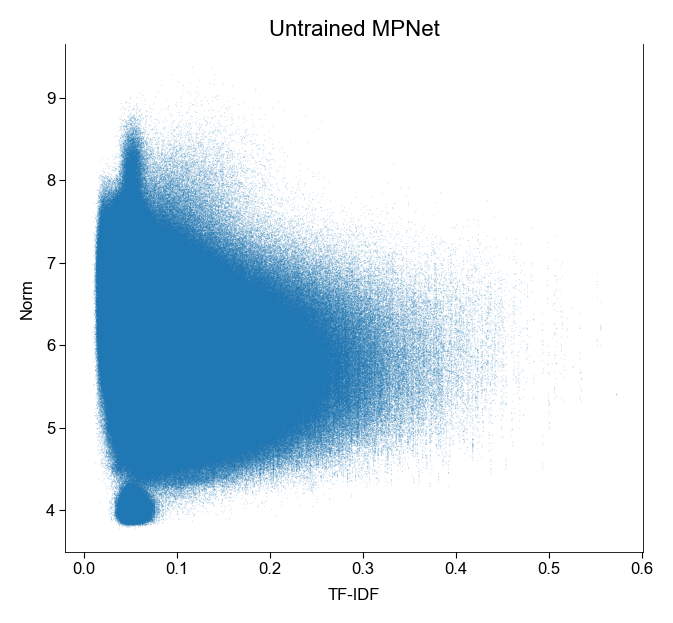

In [495]:
%%time

%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 3), dpi=200, layout="constrained")
n_not_maching = 0
for i in range(len(tfidf_original_weights_iclr)):  # 24347
    if (
        tfidf_original_weights_iclr[i].shape
        != untrained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1].shape
    ):
        n_not_maching += 1
        continue

    ax.scatter(
        tfidf_original_weights_iclr[i],
        untrained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1],
        c="tab:blue",
        s=0.5,
        alpha=0.3,
        marker=".",
        linewidths=0,
        ec="None",
        rasterized=True,
    )

print(n_not_maching)
ax.set_xlabel("TF-IDF")
ax.set_ylabel("Norm")
ax.set_title("Untrained MPNet")

fig.savefig(figures_path / "tfidf_vs_norm_untrained_mpnet.png")

### Calculate the correlation value
Average correlation in between token_norm-tfidf_weight for every abstract and have a look at the distribution of this before vs. after training.

#### ICLR data

In [ ]:
# load 
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/token_norms_experiment"
)
untrained_token_norms_iclr = np.load(
    variables_path / saving_path / "untrained_token_norms_iclr.npy",
)
trained_token_norms_iclr = np.load(
    variables_path / saving_path / "trained_token_norms_iclr.npy",
)

In [75]:
# making sure the input is the correct one
tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
inputs = tokenizer(
    iclr2024.abstract.to_list(),
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

In [76]:
%%time

untrained_correlations = np.zeros(len(tfidf_original_weights_iclr))
abstracts_to_exclude_untrained = np.zeros(
    len(tfidf_original_weights_iclr), dtype=bool
)
n_not_maching = 0
for i in range(len(tfidf_original_weights_iclr)):  # 24347
    if (
        tfidf_original_weights_iclr[i].shape
        != untrained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1].shape
    ):
        n_not_maching += 1
        abstracts_to_exclude_untrained[i] = True

        continue

    untrained_correlations[i] = sp.stats.pearsonr(
        tfidf_original_weights_iclr[i],
        untrained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1],
    )[0]
print(n_not_maching)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/token_norms_experiment"
)
np.save(
    variables_path / saving_path / "untrained_correlations_iclr",
    untrained_correlations,
)

41
CPU times: user 18.6 s, sys: 225 ms, total: 18.8 s
Wall time: 18.9 s


In [77]:
%%time

trained_correlations = np.zeros(len(tfidf_original_weights_iclr))
abstracts_to_exclude_trained = np.zeros(
    len(tfidf_original_weights_iclr), dtype=bool
)
n_not_maching = 0
for i in range(len(tfidf_original_weights_iclr)):  # 24347
    if (
        tfidf_original_weights_iclr[i].shape
        != trained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1].shape
    ):
        n_not_maching += 1
        abstracts_to_exclude_trained[i] = True

        continue

    trained_correlations[i] = sp.stats.pearsonr(
        tfidf_original_weights_iclr[i],
        trained_token_norms_iclr[i][
            inputs["attention_mask"][i].detach().cpu().numpy().astype(np.bool_)
        ][1:-1],
    )[0]
print(n_not_maching)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/token_norms_experiment"
)
np.save(
    variables_path / saving_path / "trained_correlations_iclr",
    trained_correlations,
)

41
CPU times: user 18.7 s, sys: 342 ms, total: 19 s
Wall time: 19.1 s


In [518]:
~abstracts_to_exclude_trained

array([ True,  True,  True, ...,  True,  True,  True])

CPU times: user 20.1 ms, sys: 7.4 ms, total: 27.5 ms
Wall time: 26.3 ms


(-0.8, 0.4)

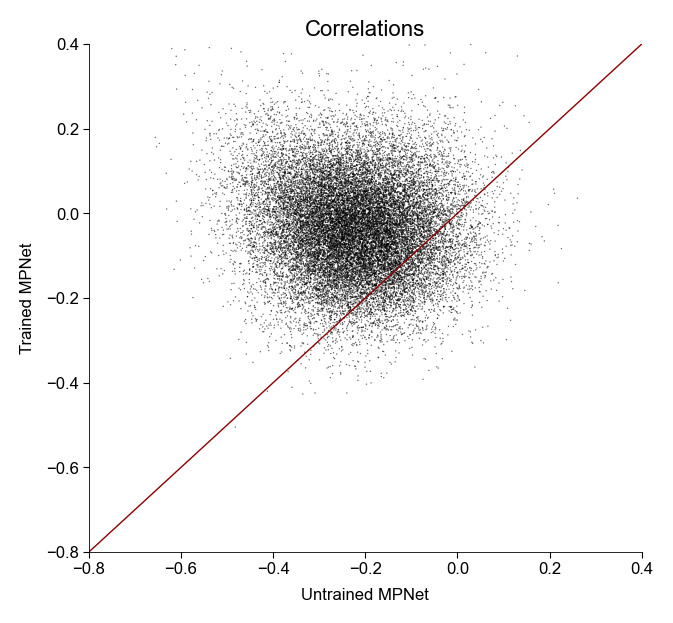

In [78]:
%%time

%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 3), dpi=200, layout="constrained")


ax.scatter(
    untrained_correlations[~abstracts_to_exclude_trained],
    trained_correlations[~abstracts_to_exclude_trained],
    c="k",
    s=1,
    alpha=0.6,
    marker=".",
    linewidths=0,
    ec="None",
    rasterized=True,
)
ax.plot([-0.8, 0.4], [-0.8, 0.4], c="darkred")
ax.set_xlabel("Untrained MPNet")
ax.set_ylabel("Trained MPNet")
ax.set_title("Correlations")
ax.set_xlim(-0.8, 0.4)
ax.set_ylim(-0.8, 0.4)
# ax.axis("equal")

# fig.savefig(figures_path / "correlations_untrained_vs_trained_mpnet.png")

In [531]:
print(np.amin(untrained_correlations))
print(np.amax(untrained_correlations))
print(np.amin(trained_correlations))
print(np.amax(trained_correlations))

-0.6552703009637801
0.26052631211973715
-0.5044657518116327
0.4797139191425215


In [535]:
bin_edges_corr = np.linspace(-1, 1, 100)

In [537]:
%%time

counts_corr_untrained, bins_untrained = np.histogram(
    untrained_correlations, bins=bin_edges_corr
)
counts_corr_trained, bins_trained = np.histogram(
    trained_correlations, bins=bin_edges_corr
)

CPU times: user 1.14 ms, sys: 54 µs, total: 1.2 ms
Wall time: 811 µs


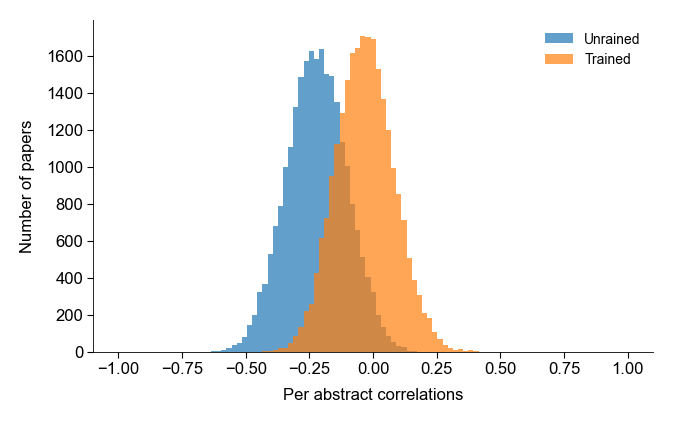

In [572]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200, layout="constrained")

ax.hist(
    bins_untrained[:-1],
    bins_untrained,
    weights=counts_corr_untrained,
    color="tab:blue",
    alpha=0.7,
    label="Unrained",
)
ax.hist(
    bins_trained[:-1],
    bins_trained,
    weights=counts_corr_trained,
    color="tab:orange",
    alpha=0.7,
    label="Trained",
)
ax.set_ylabel("Number of papers")
ax.set_xlabel("Per abstract correlations")
ax.legend()

fig.savefig(
    figures_path / "correlations_distribution_untrained_and_trained_mpnet.png"
)

### Across layers

#### Untrained

In [28]:
# making sure the input is the correct one
tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
inputs = tokenizer(
    iclr2024.abstract.to_list(),
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

In [51]:
%%time

untrained_correlations_layers_iclr = dict()
abstracts_to_exclude_untrained = np.zeros(
    len(tfidf_original_weights_iclr), dtype=bool
)
for j, layer_number in enumerate(np.arange(7) * 2):
    print("Layer : ", layer_number)

    # load norms of that layer
    # saving
    model_name = "mpnet"
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset/token_norms_experiment"
    )
    untrained_token_norms_iclr = np.load(
        variables_path
        / saving_path
        / f"untrained_token_norms_layer_{layer_number}_iclr.npy"
    )

    # initialize empty array
    untrained_correlations = np.zeros(len(tfidf_original_weights_iclr))
    n_not_maching = 0

    # compute correlations for every abstract
    for i in range(len(tfidf_original_weights_iclr)):  # 24347
        # exclude cases where abstract has weird symbols that make the number of tokens not to match with number of tfidf tokens (despite using the same tokenizer)
        if (
            tfidf_original_weights_iclr[i].shape
            != untrained_token_norms_iclr[i][
                inputs["attention_mask"][i]
                .detach()
                .cpu()
                .numpy()
                .astype(np.bool_)
            ][1:-1].shape
        ):
            n_not_maching += 1
            abstracts_to_exclude_untrained[i] = True

            continue
        # calculate correlation
        untrained_correlations[i] = sp.stats.pearsonr(
            tfidf_original_weights_iclr[i],
            untrained_token_norms_iclr[i][
                inputs["attention_mask"][i]
                .detach()
                .cpu()
                .numpy()
                .astype(np.bool_)
            ][1:-1],
        )[0]

    untrained_correlations_layers_iclr[layer_number] = untrained_correlations
    print(n_not_maching)

# save
## corr
f = open(
    variables_path / saving_path / "untrained_correlations_layers_iclr.pkl",
    "wb",
)
pickle.dump(untrained_correlations_layers_iclr, f)
f.close()

## mask -- should be the same for untrained and trained cases, and across layers
np.save(
    variables_path / saving_path / "abstracts_to_exclude_untrained",
    abstracts_to_exclude_untrained,
)

Layer :  0
41
Layer :  2
41
Layer :  4
41
Layer :  6
41
Layer :  8
41
Layer :  10
41
Layer :  12
41
CPU times: user 2min 9s, sys: 2.5 s, total: 2min 11s
Wall time: 2min 12s


#### Trained -- RERUN

In [ ]:
# # making sure the input is the correct one
# tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
# inputs = tokenizer(
#     iclr2024.abstract.to_list(),
#     padding=True,
#     truncation=True,
#     return_tensors="pt",
#     max_length=512,
# ).to(device)

In [80]:
%%time

trained_correlations_layers_iclr = dict()
abstracts_to_exclude_untrained = np.zeros(
    len(tfidf_original_weights_iclr), dtype=bool
)
for j, layer_number in enumerate(np.arange(7) * 2):
    print("Layer : ", layer_number)

    # load norms of that layer
    # saving
    model_name = "mpnet"
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset/token_norms_experiment"
    )
    trained_token_norms_iclr = np.load(
        variables_path
        / saving_path
        / f"trained_token_norms_layer_{layer_number}_iclr.npy"
    )

    # initialize empty array
    trained_correlations = np.zeros(len(tfidf_original_weights_iclr))
    n_not_maching = 0

    # compute correlations for every abstract
    for i in range(len(tfidf_original_weights_iclr)):  # 24347
        # exclude cases where abstract has weird symbols that make the number of tokens not to match with number of tfidf tokens (despite using the same tokenizer)
        if (
            tfidf_original_weights_iclr[i].shape
            != trained_token_norms_iclr[i][
                inputs["attention_mask"][i]
                .detach()
                .cpu()
                .numpy()
                .astype(np.bool_)
            ][1:-1].shape
        ):
            n_not_maching += 1
            abstracts_to_exclude_untrained[i] = True

            continue
        # calculate correlation
        trained_correlations[i] = sp.stats.pearsonr(
            tfidf_original_weights_iclr[i],
            trained_token_norms_iclr[i][
                inputs["attention_mask"][i]
                .detach()
                .cpu()
                .numpy()
                .astype(np.bool_)
            ][1:-1],
        )[0]

    trained_correlations_layers_iclr[layer_number] = trained_correlations
    print(n_not_maching)

# save
## corr
f = open(
    variables_path / saving_path / "trained_correlations_layers_iclr.pkl",
    "wb",
)
pickle.dump(trained_correlations_layers_iclr, f)
f.close()

## mask -- should be the same for untrained and trained cases, and across layers -- THAT IS WHY I DON'T SAVE IT AGAIN
# np.save(
#     variables_path / saving_path / "abstracts_to_exclude_untrained",
#     abstracts_to_exclude_untrained,
# )

Layer :  0
41
Layer :  2


#### Plot

CPU times: user 2.46 s, sys: 4.4 s, total: 6.86 s
Wall time: 1.2 s


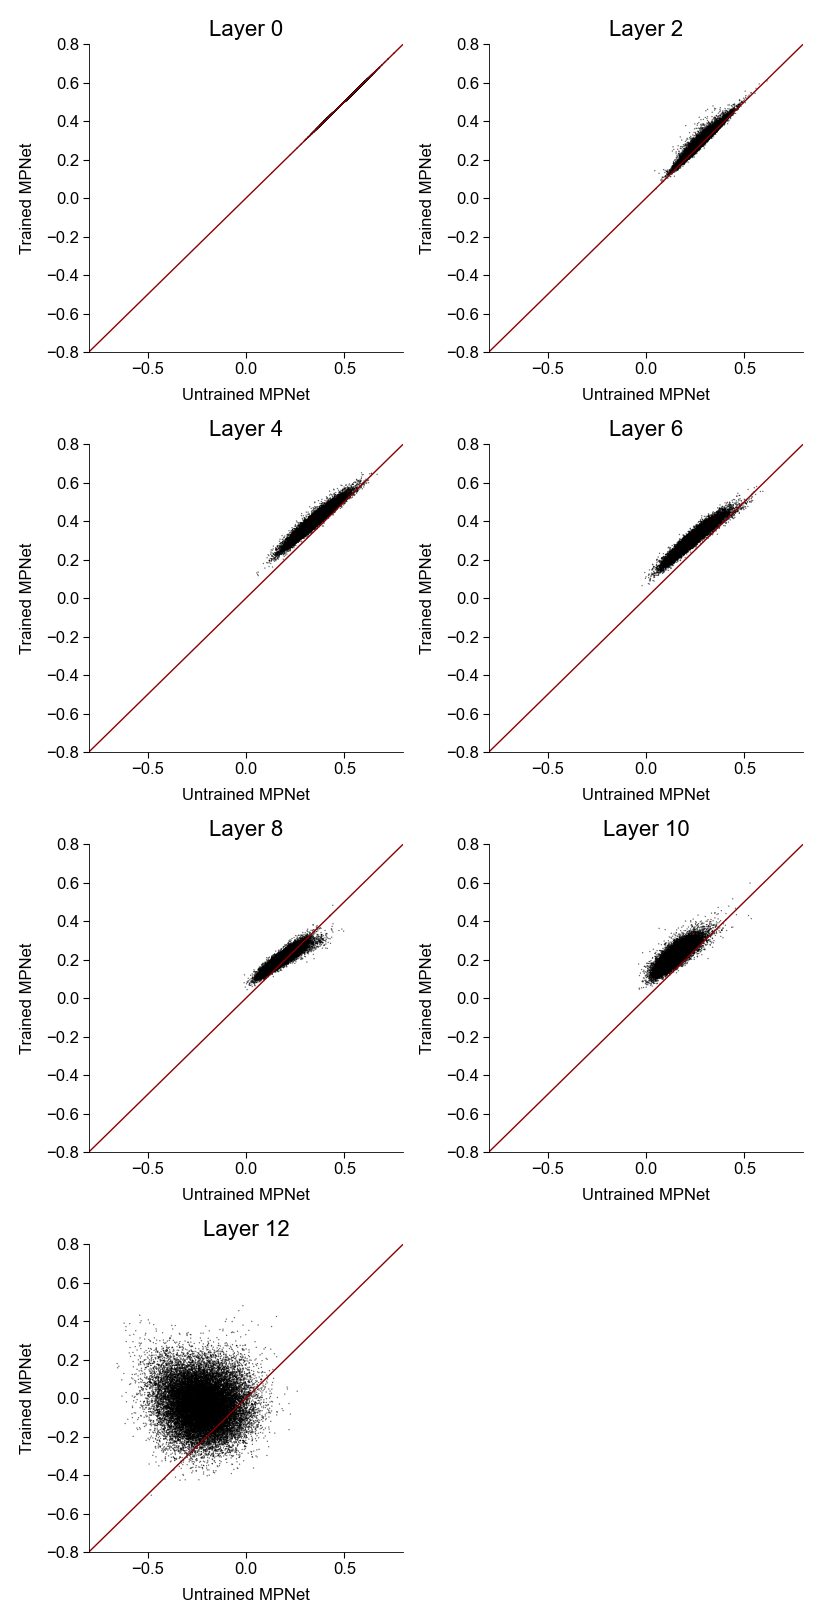

In [81]:
%%time

%matplotlib inline
fig, axs = plt.subplots(4, 2, figsize=(4, 8), dpi=200, layout="constrained")
layers = np.arange(7) * 2

# load
model_name = "mpnet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/token_norms_experiment"
)

## corr
pickle_in = open(
    variables_path / saving_path / "untrained_correlations_layers_iclr.pkl",
    "rb",
)
untrained_correlations_layers_iclr = pickle.load(pickle_in)

pickle_in = open(
    variables_path / saving_path / "trained_correlations_layers_iclr.pkl", "rb"
)
trained_correlations_layers_iclr = pickle.load(pickle_in)


## mask
abstracts_to_exclude = np.load(
    variables_path / saving_path / "abstracts_to_exclude_untrained.npy",
)

for i, ax in enumerate(axs.flatten()):
    if ax == axs.flatten()[-1]:
        ax.axis("off")
    else:
        layer_number = layers[i]
        # load

        untrained_correlations = untrained_correlations_layers_iclr[
            layer_number
        ]
        trained_correlations = trained_correlations_layers_iclr[layer_number]

        # plot
        ax.scatter(
            untrained_correlations[~abstracts_to_exclude],
            trained_correlations[~abstracts_to_exclude],
            c="k",
            s=1,
            alpha=0.6,
            marker=".",
            linewidths=0,
            ec="None",
            rasterized=True,
        )
        ax.plot([-0.8, 0.8], [-0.8, 0.8], c="darkred")
        ax.set_xlabel("Untrained MPNet")
        ax.set_ylabel("Trained MPNet")
        ax.set_title(f"Layer {layer_number}")
        ax.set_xlim(-0.8, 0.8)
        ax.set_ylim(-0.8, 0.8)
# ax.axis("equal")

fig.savefig(
    figures_path / "correlations_across_layers_untrained_vs_trained_mpnet.png"
)

CPU times: user 2.98 s, sys: 298 ms, total: 3.28 s
Wall time: 3.02 s


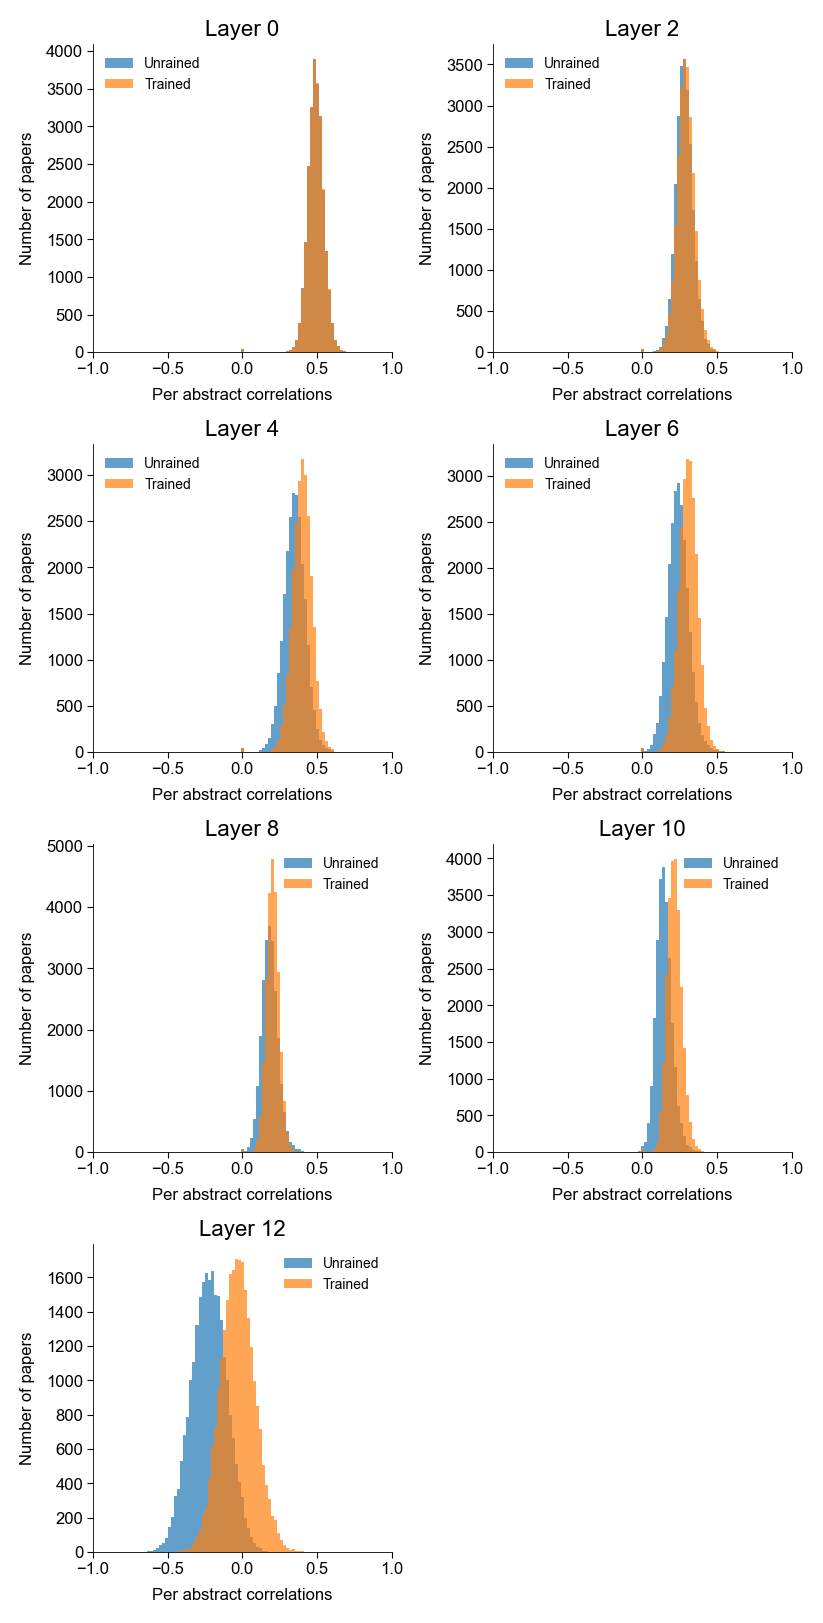

In [83]:
%%time

%matplotlib inline
fig, axs = plt.subplots(4, 2, figsize=(4, 8), dpi=200, layout="constrained")
layers = np.arange(7) * 2

# load
model_name = "mpnet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/token_norms_experiment"
)

## corr
pickle_in = open(
    variables_path / saving_path / "untrained_correlations_layers_iclr.pkl",
    "rb",
)
untrained_correlations_layers_iclr = pickle.load(pickle_in)

pickle_in = open(
    variables_path / saving_path / "trained_correlations_layers_iclr.pkl", "rb"
)
trained_correlations_layers_iclr = pickle.load(pickle_in)


## mask
abstracts_to_exclude = np.load(
    variables_path / saving_path / "abstracts_to_exclude_untrained.npy",
)
bin_edges_corr = np.linspace(-1, 1, 100)

for i, ax in enumerate(axs.flatten()):
    if ax == axs.flatten()[-1]:
        ax.axis("off")
    else:
        layer_number = layers[i]
        # get layers
        untrained_correlations = untrained_correlations_layers_iclr[
            layer_number
        ]
        trained_correlations = trained_correlations_layers_iclr[layer_number]

        # compute histogram
        counts_corr_untrained, bins_untrained = np.histogram(
            untrained_correlations, bins=bin_edges_corr
        )
        counts_corr_trained, bins_trained = np.histogram(
            trained_correlations, bins=bin_edges_corr
        )
        # plot
        ax.hist(
            bins_untrained[:-1],
            bins_untrained,
            weights=counts_corr_untrained,
            color="tab:blue",
            alpha=0.7,
            label="Unrained",
        )
        ax.hist(
            bins_trained[:-1],
            bins_trained,
            weights=counts_corr_trained,
            color="tab:orange",
            alpha=0.7,
            label="Trained",
        )
        ax.set_ylabel("Number of papers")
        ax.set_xlabel("Per abstract correlations")
        ax.legend()
        ax.set_title(f"Layer {layer_number}")
        ax.set_xlim(-1, 1)

# ax.axis("equal")

fig.savefig(
    figures_path
    / "correlations_distribution_across_layers_untrained_vs_trained_mpnet.png"
)